In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from sklearn.svm import SVC
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, recall_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
import math
import mlflow
import os

os.environ["DATABRICKS_HOST"] = "https://dbc-e0c2984f-335b.cloud.databricks.com/"
os.environ["DATABRICKS_TOKEN"] = ""
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Desarrollo_de_Soluciones/SVM_TFIDF")

2025/09/06 15:21:35 INFO mlflow.tracking.fluent: Experiment with name '/Desarrollo_de_Soluciones/XGBoost_SVM' does not exist. Creating a new experiment.


<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1121851193894853', creation_time=1757164894553, experiment_id='1121851193894853', last_update_time=1757164894553, lifecycle_stage='active', name='/Desarrollo_de_Soluciones/XGBoost_SVM', tags={'mlflow.experiment.sourceName': '/Desarrollo_de_Soluciones/XGBoost_SVM',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'j.rico566@uniandes.edu.co',
 'mlflow.ownerId': '75126365786967'}>

In [2]:
# cargar los datos

data_training = pd.read_csv("../data/cleaned_train_dataset.csv")
data_test = pd.read_csv("../data/cleaned_test_dataset.csv")
data_validation = pd.read_csv("../data/cleaned_val_dataset.csv")

In [3]:
data_training.tail()

,text,label
811,higher blood levels of pyridoxal 5'-phosphate ...,0
812,pectin-based films are wrapping that is made f...,0
813,ste20 (sterile 20)/sps-1 related proline/alani...,1
814,development of a human model of hemorrhage has...,1
815,"the local, systemic, and referred causes of fi...",1


In [4]:
# Revisar ejemplosd e los textos

for x in data_training["text"][:4]:
    print(x, "\n")

inborn errors of metabolism (iem) are hereditary diseases that affect how the body processes nutrients. they vary both in how they appear in a patient and in they underlying genetic causes. to date, more than 1000 different iem have been identified. though each individual disease is rare, taken altogether the rate has been shown to be upwards of 1 in 800. the way the diseases appear in patients can vary. this makes it difficult it diagnose them. iem are present in all ethnic groups and across every age. some iem can be treated, with promising outcomes. however, doctors suspecting these diseases from patient exams is not enough alone to reduce health problems and death. in the last decade, expanded newborn screening has become a mandatory public health strategy in most developed and developing countries. this is due to the advent of a chemical detection technology called tandem mass spectrometry. this technology allows more than 30 different metabolic disorders to be detected at low cos

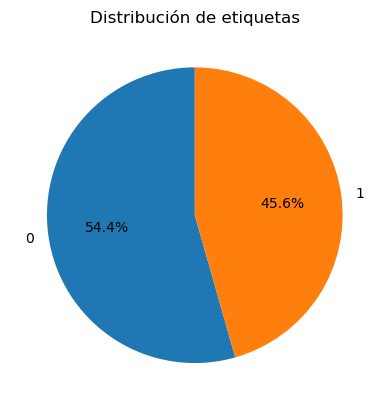

In [5]:
data_training["label"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    startangle=90,
    ylabel=""   # quita el label "label"
)
plt.title("Distribución de etiquetas")
plt.show()

In [6]:
# Crear vectores a partir de los datos

tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(data_training["text"].astype(str).tolist())
X_test = tfidf_vectorizer.transform(data_test["text"].astype(str).tolist())
X_validation = tfidf_vectorizer.transform(data_validation["text"].astype(str).tolist())


y_train = data_training["label"].astype(int).values
y_test  = data_test["label"].astype(int).values  
y_val   = data_validation["label"].astype(int).values

In [7]:
print(f"tamanio de la data vectorizada: {X_train.shape[0]} muestras de {X_train.shape[1]} dimensiones")

tamanio de la data vectorizada: 816 muestras de 10437 dimensiones


In [9]:
tfidf_grid = {
    "ngram_range": [(1,1), (1,2)],
    "min_df": [0.01, 0.05],
    "max_features": [5000, 10000],  # tamaño del vocabulario
}

svm_grid = {
    "linear": {
        "C": [0.1, 1.0, 10.0],
    },
    "rbf": {
        "C": [1.0, 10.0],
        "gamma": ["scale", 1e-3],
    },
    "poly": {
        "C": [1.0, 10.0],
        "degree": [2, 3],
        "gamma": ["scale"],
        "coef0": [0.0, 1.0],
    },
}

In [10]:
def grid_items(grid):
    keys = list(grid.keys())
    for values in product(*[grid[k] for k in keys]):
        yield dict(zip(keys, values))

In [11]:
tfidf_total = math.prod(len(v) for v in tfidf_grid.values())
svm_total = sum(math.prod(len(v) for v in space.values()) for space in svm_grid.values())
total = tfidf_total * svm_total
pbar = tqdm(total=total, desc="Runs", leave=True)


for tfidf_params in grid_items(tfidf_grid):
    vec = TfidfVectorizer(analyzer="word", max_df=0.9, sublinear_tf=True, norm="l2", **tfidf_params)
    X_train = vec.fit_transform(data_training["text"].astype(str))
    X_val   = vec.transform(data_validation["text"].astype(str))

    for kernel, space in svm_grid.items():
        for svm_params in grid_items(space):
            run_name = (
                f"tfidf_{tfidf_params['ngram_range']}_svm_{kernel}_"
                + "_".join(f"{k}{v}" for k, v in svm_params.items())
            )
            pbar.set_description(run_name)
    
            with mlflow.start_run(run_name=run_name):
                mlflow.set_tag("model_name", f"SVM_{kernel}")
                mlflow.log_param("featurizer", "tfidf")
                for k, v in tfidf_params.items():
                    mlflow.log_param(f"tfidf_{k}", v)
                mlflow.log_param("vocab_size", int(X_train.shape[1]))
                mlflow.log_param("n_train", int(X_train.shape[0]))
                mlflow.log_param("n_val", int(X_val.shape[0]))
                mlflow.log_param("svm_kernel", kernel)
                for k, v in svm_params.items():
                    mlflow.log_param(f"svm_{k}", v)
    
                model = SVC(
                    kernel=kernel,
                    probability=True,          # para predict_proba
                    class_weight="balanced",
                    random_state=42,
                    **svm_params               # C / gamma / degree / coef0 según kernel
                )
                model.fit(X_train, y_train)
    
                val_scores = model.predict_proba(X_val)[:, 1]
                val_pred = (val_scores >= 0.5).astype(int)
    
                metrics = {
                    "pr_auc": float(average_precision_score(y_val, val_scores)),
                    "roc_auc": float(roc_auc_score(y_val, val_scores)),
                    "f1": float(f1_score(y_val, val_pred)),
                    "recall": float(recall_score(y_val, val_pred)),
                    "accuracy": float(accuracy_score(y_val, val_pred)),
                }
                mlflow.log_metrics(metrics)
    
            pbar.update(1)


Runs:   0%|          | 0/120 [00:00<?, ?it/s]

🏃 View run tfidf_(1, 1)_svm_linear_C0.1 at: https://dbc-e0c2984f-335b.cloud.databricks.com/ml/experiments/1121851193894853/runs/0687c1e11af74932a86b34056d64bf86
🧪 View experiment at: https://dbc-e0c2984f-335b.cloud.databricks.com/ml/experiments/1121851193894853
🏃 View run tfidf_(1, 1)_svm_linear_C1.0 at: https://dbc-e0c2984f-335b.cloud.databricks.com/ml/experiments/1121851193894853/runs/b35afa93c7d34e8396d54ff3b9da91e5
🧪 View experiment at: https://dbc-e0c2984f-335b.cloud.databricks.com/ml/experiments/1121851193894853
🏃 View run tfidf_(1, 1)_svm_linear_C10.0 at: https://dbc-e0c2984f-335b.cloud.databricks.com/ml/experiments/1121851193894853/runs/1498bee1e3b849398df36ae8490b867a
🧪 View experiment at: https://dbc-e0c2984f-335b.cloud.databricks.com/ml/experiments/1121851193894853
🏃 View run tfidf_(1, 1)_svm_rbf_C1.0_gammascale at: https://dbc-e0c2984f-335b.cloud.databricks.com/ml/experiments/1121851193894853/runs/7719bbe8f4e64274b3201452f81ce60c
🧪 View experiment at: https://dbc-e0c2984f-3

In [12]:
print("Experimento Concluido con Exito!")

Experimento Concluido con Exito!
